In [2]:
import numpy as np
import matplotlib
import cv2
import torch
from torchvision import models
from PIL import Image, ImageStat
import matplotlib.pyplot as plt
import imutils
import math
from scipy.signal import convolve2d



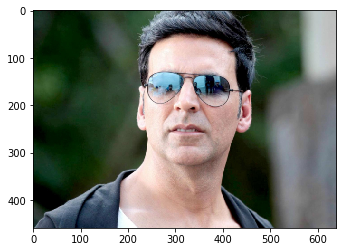

(640, 459)


In [3]:
img = Image.open('C:/Users/Akhil Jalla/Desktop/Final Project/Good Images/20160322145863414772546865.jpg')
plt.imshow(img)
plt.show()
print(img.size)


In [4]:
# image = cv2.imread('C:/Users/Akhil Jalla/Desktop/Final Project/images/10.jpg',1)
# resized_image = cv2.resize(image,(256,256))
# cv2.imshow('image',o)
# cv2.waitKey(0)
# cv2.destroyAllWindows
dlab = models.segmentation.deeplabv3_resnet101(pretrained=1).eval()

In [5]:
import torchvision.transforms as T
trf = T.Compose([T.Resize(256),
#                  T.CenterCrop(512),
                 T.ToTensor(), 
                 T.Normalize(mean = [0.485, 0.456, 0.406], 
                             std = [0.229, 0.224, 0.225])])
inp = trf(img).unsqueeze(0)

In [6]:
out = dlab(inp)['out']
print(out.shape)

torch.Size([1, 21, 256, 356])


In [7]:
om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
print (om.shape)
print (np.unique(om))

(256, 356)
[ 0 15]


In [8]:
def decode_segmap(image, nc=21):
    label_colors = np.array([(255, 255, 255),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (255, 255, 255), (0, 0, 0), (255, 255, 255), (255, 255, 255), (0, 0, 0),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (255, 255, 255), (255, 255, 255), (255, 255, 255),(255, 255, 255), (255, 255, 255)])

    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
  
    for l in range(0, nc):
        idx = image == l
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]
    
    rgb = np.stack([r, g, b], axis=2)
    return rgb

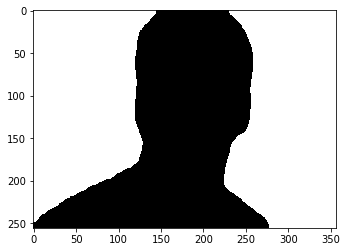

In [9]:
rgb = decode_segmap(om)
plt.imshow(rgb); plt.show()

In [10]:
print(rgb.shape)

(256, 356, 3)


In [11]:
cv_image_original = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
# resized_image = cv2.resize(cv_image_original,(512,512))
cv_image = cv2.cvtColor(np.array(rgb), cv2.COLOR_RGB2BGR)
h,w,n = cv_image.shape
print(h)
print(w)
resized_image = cv2.resize(cv_image_original,(w,h))
org_image = np.copy(resized_image)
# cv2.imshow('image',resized_image)
# cv2.imshow('image1',cv_image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

256
356


In [12]:
# image1 = cv2.imread('C:/Users/Akhil Jalla/Desktop/Final Project/images/1.jpg',1)
print(resized_image.shape)

(256, 356, 3)


In [13]:
mask = (cv_image == 0)
segmented_person = np.copy(cv_image)
segmented_person[mask] = resized_image[mask]

mask_background = (cv_image == 255)
background = np.copy(cv_image)
background[mask_background] = resized_image[mask_background]
background[np.where((background == [0,0,0]).all(axis = 2))] = [255,255,255]
# cv2.imshow('ima',resized_image)
# cv2.imshow('imag',segmented_person)
# cv2.waitKey(30000)
# cv2.destroyAllWindows

In [14]:
# gray = cv2.cvtColor(segmented_person, cv2.COLOR_BGR2GRAY)

In [15]:
# r = cv2.Laplacian(gray, cv2.CV_64F).var()
# print(r)

In [16]:
ROI = 0
blur_score_foreground = 0.0
blur_score_background = 0.0
brightness_score = 0.0
colorfulness_score = 0.0
def region_of_interest(img):
    global ROI
    number_of_black_pixels = np.count_nonzero(np.all(img==[0,0,0],axis=2))
    if number_of_black_pixels > 1000:
        ROI = 1
        print('Region of interest is present i.e ROI = 1')
    else:
        ROI = 0
        print('Region of interest is not present')
    return 

def blurriness(img,img1):
    global blur_score_foreground
    global blur_score_background
    if ROI==1:
        segmented_person_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        background_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
        blur_score_foreground = cv2.Laplacian(segmented_person_gray, cv2.CV_64F).var()
        blur_score_background = cv2.Laplacian(background_gray, cv2.CV_64F).var()
        print('Blur score of the foreground is ',blur_score_foreground)
        print('Blur score of the background is ',blur_score_background)
    else:
        blur_score = 0.0
        print('Doesnt have an ROI')
    return

def brightness(img):
    global brightness_score
    if ROI==1:
        img_pil = Image.fromarray(img)
        stat = ImageStat.Stat(img_pil)
        r,g,b = stat.mean
        brightness_score = math.sqrt(0.241*(r**2) + 0.691*(g**2) + 0.068*(b**2))
        print('Brightness score of the image is ', brightness_score)
    else:
        print('Doesnt have an ROI')
    return 

def colorfulness(img):
    global colorfulness_score
    if ROI==1:
        (b,g,r) = cv2.split(img.astype('float'))
        rg = np.absolute(r-g)
        yb = np.absolute((0.5)*(r+g)-b)
        (rbMean, rbStd) = (np.mean(rg), np.std(rg))
        (ybMean, ybStd) = (np.mean(yb), np.std(yb))

        stdRoot = np.sqrt((rbStd ** 2) + (ybStd ** 2))
        meanRoot = np.sqrt((rbMean ** 2) + (ybMean ** 2))
        colorfulness_score = stdRoot + (0.3 * meanRoot)
        print('Colourfullness score of the image is ', colorfulness_score)
    else:
        print('Doesnt have an ROI')
    return
        
def intersection_points(x1,y1,x2,y2,x3,y3,x4,y4):
    x_intercept = int( (x1*y2-y1*x2)*(x3-x4)-(x1-x2)*(x3*y4-y3*x4) ) / ( (x1-x2)*(y3-y4)-(y1-y2)*(x3-x4) )
    y_intercept = int( (x1*y2-y1*x2)*(y3-y4)-(y1-y2)*(x3*y4-y3*x4) ) / ( (x1-x2)*(y3-y4)-(y1-y2)*(x3-x4) )
    return x_intercept, y_intercept 

def contrast(img):
    img_pil = Image.fromarray(img)
    h,w = img_pil.size
    img_pil_array = np.array(img_pil)
    intensity = 0
    for i in range(img_pil_array.shape[0]):
        for j in range (img_pil_array.shape[1]):
            intensity += (img_pil_array[i,j,0] - brightness_score)**2
#     print(intensity)
    total_pixel = h * w
    contrast = math.sqrt(intensity/total_pixel)
    print('the contrast score of the image is ',contrast)
    return contrast

def noise(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    h,w = img_gray.shape
    M = [[1, -2, 1],[-2, 4, -2],[1, -2, 1]]
    sigma_noise = np.sum(np.sum(np.absolute(convolve2d(img_gray, M))))
    sigma_noise = sigma_noise * math.sqrt(0.5 * math.pi) / (6 * (w-2) * (h-2))
    print('the noise score of the image is ', sigma_noise)
    return sigma_noise

In [17]:
def ROT(img):
    new_image = np.copy(img)
    new_image[np.where((new_image == [255,255,255]).all(axis = 2))] = [125,125,125]
    new_image[np.where((new_image == [0,0,0]).all(axis = 2))] = [255,255,255]
    new_image[np.where((new_image == [125,125,125]).all(axis = 2))] = [0,0,0]
    gray_image = cv2.cvtColor(new_image, cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(gray_image,127,255,cv2.THRESH_BINARY)
    contours = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)[-2]
    countour_count = 0
    for c in contours:
        countour_count += 1
#     print(countour_count)

    M = cv2.moments(contours[0])
    # calculate x,y coordinate of centeroid
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    abc = cv2.circle(new_image, (cX, cY), 5, (0, 0, 255), -1)
    width, height, channel = abc.shape
#     print(cX)
#     print(cY)
#     print(width)
#     print(height)
#     print(channel)
#     cv2.imshow('imag',abc)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows
    horizontal_x1 = int((1/3)*height)
    horizontal_x2 = int((2/3)*height)
    vertical_x1 = int((1/3)*width)
    vertical_x2 = int((2/3)*width)
#     cv2.line(abc, (horizontal_x1, 0), (horizontal_x1, width-1), (0,255,0), 2)
#     cv2.line(abc, (horizontal_x2, 0), (horizontal_x2, width-1), (0,255,0), 2)
#     cv2.line(abc, (0, vertical_x1), (height-1, vertical_x1), (0,255,0), 2)
#     cv2.line(abc, (0, vertical_x2), (height-1, vertical_x2), (0,255,0), 2)
    x1, y1 = intersection_points(horizontal_x1,0,horizontal_x1,width-1,0,vertical_x1,height-1,vertical_x1)
    x2, y2 = intersection_points(horizontal_x2,0,horizontal_x2,width-1,0,vertical_x1,height-1,vertical_x1)
    x3, y3 = intersection_points(horizontal_x1,0,horizontal_x1,width-1,0,vertical_x2,height-1,vertical_x2)
    x4, y4 = intersection_points(horizontal_x2,0,horizontal_x2,width-1,0,vertical_x2,height-1,vertical_x2)
    
    
#     print(x1)
#     print(y1)
#     print(x2)
#     print(y2)
#     print(x3)
#     print(y3)
#     print(x4)
#     print(y4)
#     cv2.circle(abc, (118,85), 5, (255, 0, 0), -1)
#     cv2.circle(abc, (237,85), 5, (255, 0, 0), -1)
#     cv2.circle(abc, (118,170), 5, (255, 0, 0), -1)
#     cv2.circle(abc, (237,170), 5, (255, 0, 0), -1)
    cv2.imshow('imag',abc)
    cv2.waitKey(20000)
    cv2.destroyAllWindows
    dist_ROT = min((np.sqrt((cX-x1)**2 + (cY-y1)**2)),(np.sqrt((cX-x2)**2 + (cY-y2)**2)),(np.sqrt((cX-x3)**2 + (cY-y3)**2)),(np.sqrt((cX-x4)**2 + (cY-y4)**2))) 
#     print(dist_ROT)
    contour_area = cv2.contourArea(contours[0])
    Area_ratio = contour_area/(width*height)
#     print(contour_area)
#     print(Area_ratio)
    ROT_score = ((contour_area*0.05)/(height*width))*(1-((dist_ROT)/(np.sqrt(height**2 + width**2))))
    print('Ratio of area of foreground to the area of image is ', Area_ratio)
    print('The rule of third score of the image is ', ROT_score)
    return ROT_score, Area_ratio

def distance_from_center(img):
    new_image = np.copy(img)
    new_image[np.where((new_image == [255,255,255]).all(axis = 2))] = [125,125,125]
    new_image[np.where((new_image == [0,0,0]).all(axis = 2))] = [255,255,255]
    new_image[np.where((new_image == [125,125,125]).all(axis = 2))] = [0,0,0]
    gray_image = cv2.cvtColor(new_image, cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(gray_image,127,255,cv2.THRESH_BINARY)
    contours = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)[-2]
    countour_count = 0
    for c in contours:
        countour_count += 1
    M = cv2.moments(contours[0])
    # calculate x,y coordinate of centeroid
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    width, height, channel = new_image.shape
    X1 = int((1/2)*height)
    Y1 = 0
    X2 = int((1/2)*height)
    Y2 = int(width - 1)
    dist = distance(cX,cY,X1,Y1,X2,Y2)
    ratio = dist/(0.5*height)
    return ratio

def distance(x0,y0,x1,y1,x2,y2):
    numerator = abs((y2 - y1) * x0 - (x2 - x1) * y0 + x2 * y1 - y2 * x1)
    denominator = ((y2 - y1)**2 + (x2 - x1) ** 2) ** 0.5
    result = numerator/denominator
    return result
    
    

In [18]:
region_of_interest(rgb)
blurriness(segmented_person,background)
brightness(resized_image)
contrast(resized_image)
# print(ROI)
#print(blur_score)
colorfulness(resized_image)
noise(resized_image)
ROT(cv_image)
 


Region of interest is present i.e ROI = 1
Blur score of the foreground is  1527.5405089833823
Blur score of the background is  1731.4440874306333
Brightness score of the image is  98.67836800791028
the contrast score of the image is  71.9242414043395
Colourfullness score of the image is  25.69345103031319
the noise score of the image is  1.7419778570762412
Ratio of area of foreground to the area of image is  0.40093376931179775
The rule of third score of the image is  0.017346631931779283


(0.017346631931779283, 0.40093376931179775)

In [18]:
distance_from_center(cv_image)

0.109375

In [19]:
# cv2.imshow('imag',cv_image)
# # cv2.imshow('image',segmented_person)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
    
    


In [20]:
def potrait_or_landscape(img):
    width,height,channel = img.shape
    if width > height:
        potrait = 1
        landscape = 0
        print('the image is in potrait mode')
    elif height>width:
        potrait = 0
        lanscape = 1
        print('the image is in landscape mode')
    elif height==width:
        potrait = 1
        lanscape = 1
        print('the image is a square image')
    return potrait, landscape

In [21]:
potrait_or_landscape(cv_image)


the image is in landscape mode


UnboundLocalError: local variable 'landscape' referenced before assignment